# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(style="ticks", context="paper")

from tqdm.notebook import tqdm as tqdm

In [2]:
import tensorflow as tf

In [3]:
from bernstein_paper.data.cer_data_loader import load_data

# Function definitions

In [4]:
def plot_patches(ds,
                 x_vdim=7,
                 x_hdim=48,
                 y_vdim=7,
                 y_hdim=48,
                 N=3,
                 historic_columns=[],
                 horizon_columns=[],
                 title_map={},
                 y_label_map={},
                 xy_ch_connect=None,
                 gridspec_kw={},
                 fig_kw={},
                 heatmap_kw={}):
    x,y = next(ds.take(1).as_numpy_iterator())
    x_patches = x[:N]
    y_patches = y[:N]
    
    fig = plt.figure(**fig_kw)
    gs = fig.add_gridspec(2, N,**gridspec_kw)

    last_y_ax={}
    
    y_label_kw=dict(rotation=0,
                    labelpad=20,
                    verticalalignment='center_baseline',
                    horizontalalignment='right')

    x_vmin=x_patches[:N].min(axis=1).min(axis=0)
    x_vmax=x_patches[:N].max(axis=1).max(axis=0)
    
    y_off = np.where(len(horizon_columns),y_vdim,0)
    x_off = np.where(len(horizon_columns),x_vdim,0)
    
    for n in range(N):
        x=x_patches[n]
        x_ch = x.shape[1]

        x=x.reshape(-1,x_hdim,x_ch)

        sgs = gs[0,n].subgridspec(nrows=x_ch,
                                  ncols=1,
                                  hspace=0.1,
                                  wspace=0.1)

        for c in range(x_ch):
            ax = fig.add_subplot(sgs[c])
            sns.heatmap(x[:,:,c],
                        ax=ax,
                        linewidth=0.2,
                        xticklabels=c==0,
                        yticklabels=n==0,
                        cbar=False,
                        vmin=x_vmin[c],
                        vmax=x_vmax[c],
                        **heatmap_kw.get('x',{}).get(c,{}))
            if n==0:
                ax.set_ylabel(y_label_map.get('x',{}).get(c,f'x-ch-{c}'),
                              **y_label_kw)
            if c==0:
                ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
                ax.set_title(title_map.get('x','x'))
            if n>0 and xy_ch_connect is not None and c==xy_ch_connect[1][0]:
                patch = matplotlib.patches.ConnectionPatch(
                    xyA=(1, 0.5/y_vdim),
                    xyB=(0.0, ((x_vdim + y_off) - xy_ch_connect[1][1] - 0.5)/(x_vdim + y_off)),
                    coordsA="axes fraction",
                    coordsB="axes fraction",
                    axesA=last_y_ax[xy_ch_connect[0][0]],
                    axesB=ax,
                    arrowstyle='->',
                    connectionstyle="arc,angleA=0,armA=7,angleB=-180,armB=7,rad=3",
                    color='k'
                )
                ax.add_artist(patch)
            if n==(N-1) and c + 1 in historic_columns:
                ax.annotate('History',
                            xy=(1, (0.5*x_vdim + y_off)/(x_vdim+y_off)),
                            xytext=(1.05, (0.5*x_vdim + y_off)/(x_vdim+y_off)),
                            xycoords='axes fraction',
                            ha='left', va='center',
                            bbox=dict(boxstyle='square', fc='white'),
                            arrowprops=dict(arrowstyle=f'-[, widthB={x_vdim/2 - 0.2}, lengthB=0.2',
                                            color='k'))
            if n==(N-1) and c + 1 in horizon_columns:
                ax.annotate('Horizon',
                            xy=(1, (0.5*y_vdim)/(x_off+y_vdim)),
                            xytext=(1.05, (0.5*y_vdim)/(x_off+y_vdim)),
                            xycoords='axes fraction',
                            ha='left', va='center',
                            bbox=dict(boxstyle='square', fc='white'),
                            arrowprops=dict(arrowstyle=f'-[, widthB={y_vdim/2 - 0.2}, lengthB=0.2',
                                            color='k'))

        y_ch = y_patches.shape[2]
        y=y_patches[n].reshape(y_vdim,y_hdim,y_ch)

        sgs = gs[1,n].subgridspec(nrows=y_ch,
                                   ncols=1,
                                   #hspace=0.1,
                                   wspace=0.1)
        for c in range(y_ch):
            ax = fig.add_subplot(sgs[c])
            sns.heatmap(y[:,:,c],
                        ax=ax,
                        linewidth=0.2,
                        xticklabels=False,
                        yticklabels=n==0,
                        cbar=False,
                        vmin=x_vmin[c],
                        vmax=x_vmax[c],
                        **heatmap_kw.get('y',{}).get(c,{}))
            if n==0:
                ax.set_ylabel(y_label_map.get('y',{}).get(c,f'y-ch-{c}'),
                              **y_label_kw)
            if c==0:
                ax.set_title(title_map.get('y','y'))

            last_y_ax.update({c:ax})

In [5]:
def sample_and_plot(path,
                    x_vdim,
                    x_hdim,
                    y_vdim,
                    y_hdim,
                    shift,
                    N=3,
                    historic_columns=[1, 2, 3],
                    horizon_columns=[2, 3],
                    prediction_columns=[1],
                    shuffle_buffer_size = 0,
                    **kwds):

    history_size=x_vdim*x_hdim
    horizon_size=y_vdim*y_hdim

    columns=sorted(list(set(historic_columns + horizon_columns + prediction_columns)))
    idx={k:i for i,k in enumerate(columns)}
    
    height_ratios=[len(set(historic_columns + horizon_columns))*(np.where(len(historic_columns),x_vdim,0)+np.where(len(horizon_columns),y_vdim,0)),
                   len(prediction_columns)*y_vdim]

    fig_height=sum(height_ratios) + min(len(historic_columns),1) + min(len(prediction_columns),1)
    fig_height/=5
    fig_width=N*(max(x_hdim, y_hdim) + min(N-1,1))/7

    ds = gen_ds(path,
                history_size=history_size,
                horizon_size=horizon_size,
                historic_columns=historic_columns,
                horizon_columns=horizon_columns,
                prediction_columns=prediction_columns,
                shuffle_buffer_size=shuffle_buffer_size,
                **kwds)

    plot_patches(ds,
                 N=N,
                 x_hdim=x_hdim,
                 x_vdim=x_vdim,
                 y_hdim=y_hdim,
                 y_vdim=y_vdim,
                 historic_columns=historic_columns,
                 horizon_columns=horizon_columns,
                 title_map = {'x':'Input Data',
                              'y':'Prediction Target'},
                 y_label_map = {'x':{
                                  0:'Load',
                                  1:'Temperature',
                                  2:'Is Holiday'},
                                'y':{
                                  0:'Load'}},
                 fig_kw={'figsize':(fig_width,fig_height)},
                 heatmap_kw={'x':{
                                 0:{'cmap':'OrRd'},
                                 1:{'cmap':'RdBu_r'},
                                 2:{'cmap':'binary'}},
                             'y':{
                                 0:{'cmap':'OrRd'}}},
                 gridspec_kw={'height_ratios':height_ratios,
                              'hspace':2/fig_height,
                              'wspace':1/fig_width},
                 xy_ch_connect=((0,0),(0,x_vdim+y_vdim-1-shift//x_hdim)) if shuffle_buffer_size == 0 else None)

In [6]:
def gen_ds(path,
           history_size,
           horizon_size,
           historic_columns=[1, 2, 3],
           horizon_columns=[2, 3],
           prediction_columns=[1],
           cycle_length=100,
           shift=None,
           batch_size = 32,
           shuffle_buffer_size = 0,
           seed=42):

    shift = shift or horizon_size
    
    window_size = history_size+horizon_size
    columns=sorted(list(set(historic_columns + horizon_columns + prediction_columns)))
    idx={k:i for i,k in enumerate(columns)}
    
    def stack_features(*features):
        stacked_features = tf.stack(features)

        return stacked_features

    def sub_to_patch(sub):
        return sub.batch(window_size, drop_remainder=True)

    def process_patch(patch):
        y = tf.stack([patch[history_size:, idx[i]] for i in sorted(prediction_columns)], axis=1)

        x_hist = []
        x_hori = []
        x_columns = sorted(set(historic_columns + horizon_columns))
        if len(x_columns) == 0:
            ValueError('No feature columns provided')

        for ch in x_columns:
            p = patch[:history_size, idx[ch]]
            if ch in historic_columns:
                x_hist.append(p)
            else:
                x_hist.append(tf.zeros_like(p))
            p = patch[history_size:, idx[ch]]
            if ch in horizon_columns:
                x_hori.append(p)
            else:
                x_hori.append(tf.zeros_like(p))
                
        x_hist=tf.stack(x_hist,axis=1)
        x_hori=tf.stack(x_hori,axis=1)
        
        if len(historic_columns) == 0:
            x = x_hori
        elif len(horizon_columns) == 0:
            x = x_hist
        else:
            x = tf.concat([x_hist, x_hori],axis=0)

        return x, y

    def generate_patch(path):
        ds = tf.data.experimental.CsvDataset(
            path,
            select_cols = columns,
            record_defaults=[.0]*len(columns),
            header=True
        )

        ds = ds.map(stack_features)

        ds = ds.window(
            size=window_size,
            shift=shift,
            #stride=1,
            drop_remainder=True
        )

        ds = ds.flat_map(sub_to_patch)

        ds = ds.map(process_patch)

        return ds
    
    ds = tf.data.Dataset.list_files(path,
                                    shuffle=True,
                                    seed=seed)
    ds = ds.interleave(generate_patch, cycle_length=cycle_length)
    
    if shuffle_buffer_size > 0:
        ds = ds.shuffle(shuffle_buffer_size, seed=seed)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(1)
    
    return ds

In [7]:
class MyMinMaxScaler():
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range

    def fit(self, X):
        self.min = X.min()
        self.max = X.max()

    def transform(self, X, Y=None):
        X_std = (X - self.min) / (self.max - self.min)
        X_scaled = X_std * \
            (self.feature_range[1] - self.feature_range[0]
             ) + self.feature_range[0]
        return X_scaled if Y is None else (X_scaled, self.transform(Y))

    def fit_transform(self, X, Y=None):
        self.fit(X)
        return self.transform(X, Y)


class CERDataScaler():
    def __init__(self, load_col=0, weather_col=1):
        self.load_col = load_col
        self.weather_col = weather_col
        self.load_scaler = MyMinMaxScaler(feature_range=(0, 1))
        self.weather_scaler = MyMinMaxScaler(feature_range=(-1, 1))

    def fit(self, X):
        load_data = X[:, :, self.load_col]
        weather_data = X[:, :, self.weather_col]

        self.load_scaler.fit(load_data)
        self.weather_scaler.fit(weather_data)

    def transform(self, X, Y=None):
        load_data = X[:, :, self.load_col]
        weather_data = X[:, :, self.weather_col]

        X[:, :, self.load_col] = self.load_scaler.transform(load_data)
        X[:, :, self.weather_col] = self.weather_scaler.transform(
            weather_data)
        if Y is not None:
            Y = self.load_scaler.transform(Y)

            return X, Y
        else:
            return X

    def fit_transform(self, X, Y=None):
        self.fit(X)
        return self.transform(X, Y)


# Tensorflow Dataset

In [17]:
data_path="../../data/CER Electricity Revised March 2012/preprocessed/mini/"

In [18]:
x_vdim=3
x_hdim=48
y_vdim=1
y_hdim=48
history_size=x_vdim*x_hdim
horizon_size=y_vdim*y_hdim

gen_ds_kwds=dict(
    history_size=history_size,
    horizon_size=horizon_size,
    historic_columns=[1, 2, 3],
    horizon_columns=[2, 3],
    prediction_columns=[1],
    shift=horizon_size,
    cycle_length=1000,
    shuffle_buffer_size=10)

In [20]:
ds = gen_ds(os.path.join(data_path,'*.csv'),
            **gen_ds_kwds)

In [21]:
for x,y in ds.take(1):
    print(x.shape)

(32, 192, 3)


# Plot examples

In [22]:
x_vdim=3
x_hdim=48
y_vdim=1
y_hdim=48

gen_ds_kwds=dict(
    x_vdim=x_vdim,
    x_hdim=x_hdim,
    y_vdim=y_vdim,
    y_hdim=y_hdim,
    historic_columns=[1, 2, 3],
    horizon_columns=[2, 3],
    prediction_columns=[1],
    shift=horizon_size,
    cycle_length=1,
    shuffle_buffer_size=0)

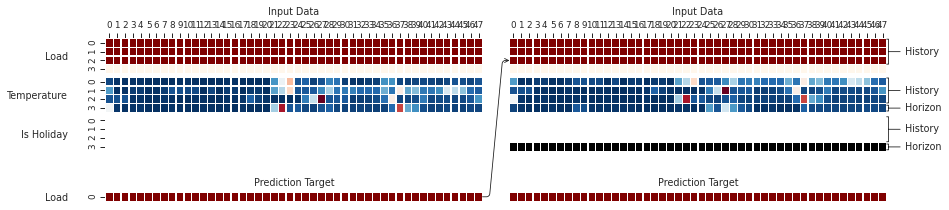

In [24]:
sample_and_plot(os.path.join(data_path,'*.csv'), 
                N=2,
                **gen_ds_kwds)

In [25]:
x_vdim=3
x_hdim=48
y_vdim=1
y_hdim=48

gen_ds_kwds=dict(
    x_vdim=x_vdim,
    x_hdim=x_hdim,
    y_vdim=y_vdim,
    y_hdim=y_hdim,
    historic_columns=[1, 2, 3],
    horizon_columns=[2, 3],
    prediction_columns=[1],
    shift=horizon_size,
    cycle_length=100,
    shuffle_buffer_size=10000)

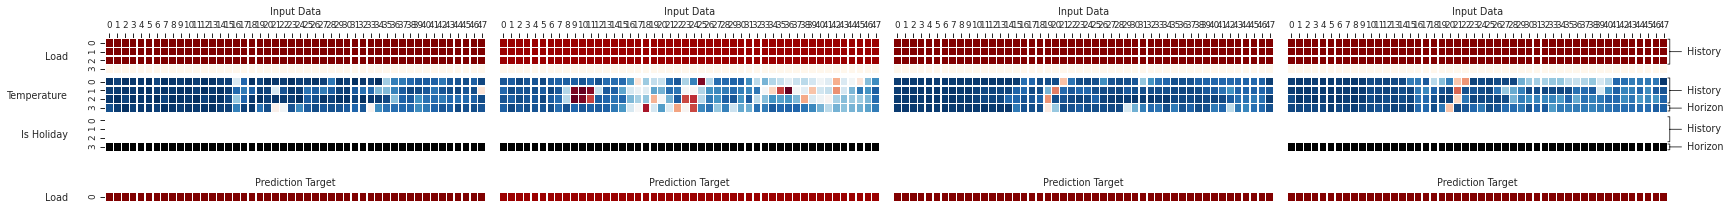

In [28]:
sample_and_plot(os.path.join(data_path,'*.csv'), 
                N=4,
                **gen_ds_kwds)